In [5]:
using LinearAlgebra
using Plots

In [6]:
pts = [(0,0),(1,1),(2,3),(1,4),(0,4),(-1,3),(0,1),(1,0)]


8-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (1, 1)
 (2, 3)
 (1, 4)
 (0, 4)
 (-1, 3)
 (0, 1)
 (1, 0)

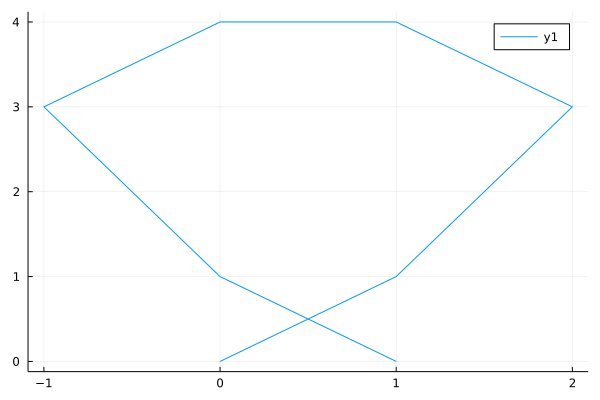

In [7]:
plot(pts)

In [35]:
function bi(t, i, n)
    return binomial(n, i) * (t^i) * ((1-t)^(n-i))
end

bi (generic function with 1 method)

In [81]:
function bezier(pts, num=100)
    t = LinRange(0, 1, num)
    display(t)
    n = length(pts)
    B = zeros(Float64, (num, 2))
    for ti=1:num
        for i=1:n
            c = bi(t[ti], i-1, num)
            B[ti, 1] += c * pts[i][1]
            B[ti, 2] += c * pts[i][2]
        end
    end
    B[1, 1] = pts[1][1]
    B[1, 2] = pts[1][2]
    B[num, 1] = pts[n][1]
    B[num, 1] = pts[n][1]
    return B
end

bezier (generic function with 2 methods)

In [84]:
x = bezier(pts, 1000)
x

1000-element LinRange{Float64, Int64}:
 0.0,0.001001,0.002002,0.003003,0.004004,…,0.996997,0.997998,0.998999,1.0

1000×2 Matrix{Float64}:
 0.0        0.0
 0.794912   1.23737
 0.960388   2.28847
 0.741594   2.74565
 0.463178   2.6503
 0.269579   2.22109
 0.169019   1.67957
 0.123766   1.17315
 0.100471   0.76889
 0.0823264  0.47821
 ⋮          
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 1.0        0.0

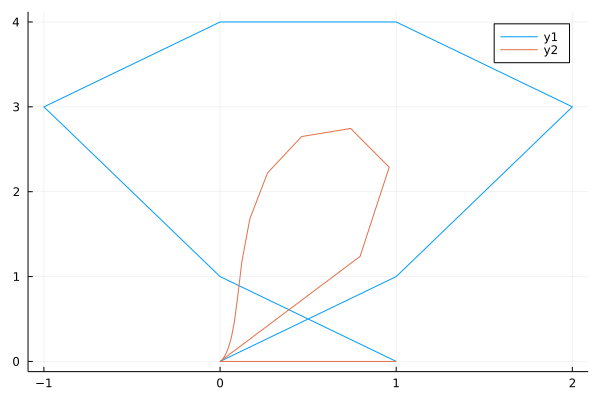

In [85]:
plot(pts)
plot!(x[:, 1], x[:, 2])

In [87]:
pts_ = zeros((length(pts), 2))
for i=1:length(pts)
    pts_[i,1] = pts[i][1]
    pts_[i,2] = pts[i][2]
end

In [88]:
pts_

8×2 Matrix{Float64}:
  0.0  0.0
  1.0  1.0
  2.0  3.0
  1.0  4.0
  0.0  4.0
 -1.0  3.0
  0.0  1.0
  1.0  0.0

In [94]:
prod(pts_[:, 1])

-0.0

In [117]:
# recursive

function rec_bez(pts, num)
    t = LinRange(0, 1, num)
    n = length(pts)
    B = zeros(Float64, (num, 2))
    # B[1, 1] = pts[1][1]
    # B[1, 2] = pts[1][2]
    for ti=1:num
        B[ti, :] = deCasteljau(t[ti], pts)
    end
    return B
end

rec_bez (generic function with 1 method)

In [120]:
function deCasteljau(t, pts)
    B = deepcopy(pts)
    n = size(pts)[1]
    for j=1:n
        for k=1:n-j
            B[k, :] = B[k, :] * (1-t) + B[k+1, :] * t
        end
    end
    return B[1, :]
end

deCasteljau (generic function with 1 method)

In [121]:
x = rec_bez(pts_, 100)

100×2 Matrix{Float64}:
 0.0        0.0
 0.0706364  0.0727783
 0.14086    0.149419
 0.210288   0.229515
 0.278571   0.312675
 0.345388   0.398525
 0.410449   0.486705
 0.47349    0.576871
 0.534274   0.668692
 0.59259    0.761854
 ⋮          
 0.465726   0.668692
 0.52651    0.576871
 0.589551   0.486705
 0.654612   0.398525
 0.721429   0.312675
 0.789712   0.229515
 0.85914    0.149419
 0.929364   0.0727783
 1.0        0.0

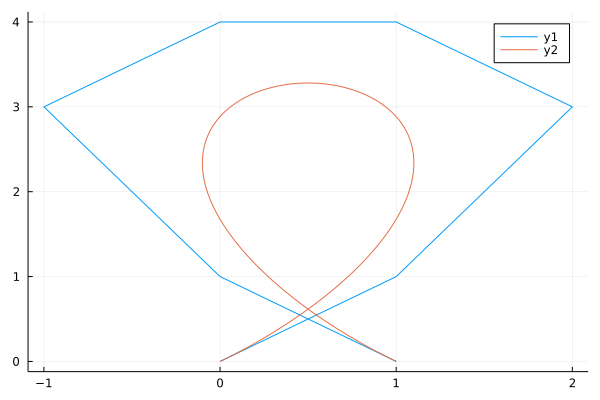

In [122]:
plot(pts)
plot!(x[:, 1], x[:, 2])